# Part 2.2 - Train Final XGBoost Classifier
We will use XGBoost to train a model for predicting the astronomical classes. XGBoost uses a machine learning technique called gradient boosting. Similar in concept to random forests, gradient boosting uses an ensemble of decision trees for prediction.

While random forest ensembles can be built in parallel, gradient boosting ensembles are built by iteratively adding decision trees, which minimize some objective function, to the forest. Each iteration is focused on improving predictions for observations that performed poorly in previous iterations.

In [29]:
import cudf as gd
import pandas as pd
import numpy as np
import math
import xgboost as xgb
from termcolor import colored
import matplotlib.pyplot as plt

from utils import xgb_cross_entropy_loss, cross_entropy

from cuml.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

In [30]:
train_final_gd = gd.from_pandas(pd.read_pickle("train_gdf.pkl"))
test_final_gd = gd.from_pandas(pd.read_pickle("test_gdf.pkl"))

In [31]:
train_final_gd.head().to_pandas()

,object_id,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,mean_passband,mean_detected,...,bottleneck6,bottleneck7,bottleneck8,bottleneck9,bottleneck10,bottleneck11,bottleneck12,bottleneck13,bottleneck14,bottleneck15
0,191287,1,0.0000,0.0000,0.0000,NaN,0.021,65,2.336364,0.009091,...,6.283429,4.718782,1.619317,3.202919,5.222532,1.556044,4.114704,5.098020,0.048073,22.705059
1,191334,1,0.7632,0.7703,0.0329,43.401703,0.018,88,2.457386,0.514205,...,6.650832,10.496398,5.117399,2.728088,11.196789,0.556514,5.458009,2.808542,4.856879,14.684568
2,191397,1,0.3497,0.3083,0.0328,41.024101,0.023,90,2.336364,0.172727,...,20.268698,5.112232,3.696377,14.837788,1.480759,0.629527,3.716055,0.774229,16.195549,5.821880
3,191667,1,0.1447,0.1576,0.0135,39.383701,0.023,42,2.457386,0.224432,...,22.291304,9.205591,2.537441,1.873690,6.381655,9.245475,12.489989,0.447020,20.799400,14.036156
4,191847,1,0.0000,0.0000,0.0000,NaN,0.009,65,2.400000,0.017143,...,6.598294,5.393848,4.306551,1.066992,6.304627,1.928597,0.974238,2.365771,2.735358,10.880499


Let's extract the set of unique classes from our training set

In [32]:
y = train_final_gd['target']
classes = sorted(np.unique(y.to_array()))

Since our classifier will expect labels to be in the range `(0, n_classes-1)`, we can use cuML's `LabelEncoder()` function to encode them in the training dataset. 

In [33]:
y = LabelEncoder().fit_transform(y).to_array()

Preprocess our columns to fill `nan` values with zeros

In [34]:
cols = [i for i in test_final_gd.columns if i not in ['object_id','target']]
for col in cols:
    train_final_gd[col] = train_final_gd[col].fillna(0).astype('float32')

for col in cols:
    test_final_gd[col] = test_final_gd[col].fillna(0).astype('float32')

Perform a stratified split of our training dataset into 90% training and 10% validation datasets. 

In [35]:
X = train_final_gd[cols].as_matrix()
Xt = test_final_gd[cols].as_matrix()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,stratify=y)

XGBoost models are configured using a dict for parameters. You can learn more about the various different configuration parameters in the XGBoost [docs](https://xgboost.readthedocs.io/en/latest/parameter.html). 

In [36]:
gpu_params = {
            'objective': 'multi:softprob',    # softmax, return probabilities for each class
            'nthread': 16,
            'num_class':len(classes),
            'max_depth': 7,
            'silent': 1,
            'subsample':0.7,
            'colsample_bytree': 0.7,
            "tree_method": "gpu_hist"         # compute histograms for splits on GPU
}

Build DMatrix objects with our train, validation, and test datasets 

In [37]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dvalid = xgb.DMatrix(data=X_test, label=y_test)
dtest = xgb.DMatrix(data=Xt)

Train our XGBoost model

In [38]:
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]

clf = xgb.train(gpu_params, 
                dtrain=dtrain,
                num_boost_round=60,
                evals=watchlist,
                feval=xgb_cross_entropy_loss(classes),
                early_stopping_rounds=10,
                verbose_eval=1000)

[0]	eval-merror:0.230573	train-merror:0.195243	eval-wloss:1.66247	train-wloss:1.58968
Multiple eval metrics have been passed: 'train-wloss' will be used for early stopping.

Will train until train-wloss hasn't improved in 10 rounds.
[59]	eval-merror:0.157962	train-merror:0	eval-wloss:0.73674	train-wloss:0.024258


In [39]:
yp = clf.predict(dvalid)

gpu_loss = cross_entropy(y_test, yp, classes)

ysub = clf.predict(dtest)

line = 'validation loss %.4f'%gpu_loss
print(colored(line,'green'))

validation loss 0.7367


A confusion matrix will give us a good indication of the accuracy for each class

In [40]:
y_pred = np.argmax(yp, axis=1)

Normalized confusion matrix


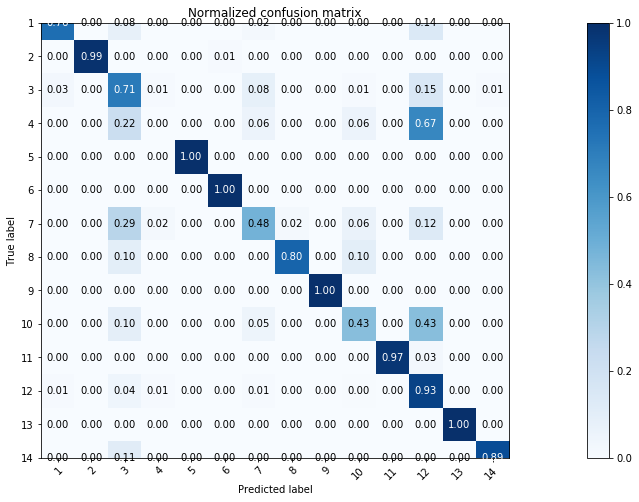

In [41]:
from utils import plot_confusion_matrix
plot_confusion_matrix(y_test, y_pred, np.arange(1, len(classes)+1), normalize=True)

## Independent Exercise

Now that you have trained an XGBoost model using both the timeseries embeddings and the statistical features,
1. re-run the previous notebook, but don't merge the timseries features into your training and test datasets before storing them. 
2. Use your new dataset to train a new XGBoost classifier. 
3. Compare the accuracy and confusion matrix against the model that included the timeseries embedding features. 